In [1]:
import json
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
import sqlalchemy as sal
from sqlalchemy import text

%matplotlib inline

In [2]:
# csv paths
nutrient_matrix_data_p = r"../../data/Nutrients_Branded_Foods_2018/"

nutrient_matrix_csv_p = nutrient_matrix_data_p + "nutrients_matrix.csv.gz"

# nourish db connection config
nourish_user = "gmichael"

nourish_pswd = "567khcwx3s"

#### Import cleaned nutrient data. Set the NDB Number to the index. Remove zero rows.

In [3]:
#read data
nutrients_matrix = pd.read_csv(nutrient_matrix_csv_p)
#set ndb no as index
nutrients_matrix.set_index("NDB_No", inplace = True)
#create a list of indices where all entries are zero
nutrients_zero_rows = nutrients_matrix.loc[(nutrients_matrix==0).all(axis=1)].index
#filter out indicies where all entires are zero
nutrients_matrix = nutrients_matrix[~nutrients_matrix.index.isin(nutrients_zero_rows)]
print(nutrients_matrix.shape)
nutrients_matrix.head()

(234247, 94)


,"Calcium, Ca","Carbohydrate, by difference",Cholesterol,Energy,"Fatty acids, total saturated","Fatty acids, total trans","Fiber, total dietary","Iron, Fe",Protein,"Sodium, Na",...,18:2 undifferentiated,Glucose (dextrose),Starch,Lutein + zeaxanthin,"Fluoride, F","18:2 n-6 c,c","Choline, from phosphotidyl choline","18:3 n-3 c,c,c (ALA)",Epigallocatechin-3-gallate,Vitamin D3 (cholecalciferol)
NDB_No,,,,,,,,,,,,,,,,,,,,,
45001524,50.0,35.00,25.0,200.0,3.75,0.0,0.0,0.0,2.5,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45001528,0.0,43.24,0.0,162.0,0.00,0.0,0.0,0.0,0.0,703.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45001529,0.0,41.18,0.0,176.0,0.00,0.0,0.0,0.0,0.0,676.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45001530,0.0,34.29,0.0,143.0,0.00,0.0,0.0,0.0,0.0,971.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45001531,0.0,45.95,0.0,189.0,0.00,0.0,0.0,0.0,0.0,757.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Import the product data for reference

In [4]:
engine = sal.create_engine('postgresql+psycopg2://' + nourish_user + ':' + nourish_pswd + '@awesome-hw.sdsc.edu/nourish')
conn = engine.connect()

In [5]:
query_products = text('''SELECT "NDB_Number", "long_name", "manufacturer" From "Products_Branded_Foods_2018" ''')
result = conn.execute(query_products)
product_data = [i for i in result]
product_data = pd.DataFrame(product_data)
product_data.set_index("NDB_Number", inplace = True)
product_data.head(2)

,long_name,manufacturer
NDB_Number,,
45265623,MINI CHURROS,"Nong Shim Co., Ltd."
45265624,CURLY CANES,"Frankford Candy, LLC"


Example of product with zero values

In [6]:
product_data[product_data.index.isin(nutrients_zero_rows)]

,long_name,manufacturer
NDB_Number,,
45265922,NATURAL ENERGY PREMIUM BLACK TEA,Lipton
45266011,APPLE CIDER VINEGAR,The Moran Group Incorporated
45266216,SELTZER,Polar Corporation
45266289,APPLE CIDER VINEGAR,Pastorelli Food Products Inc.
45266419,NATURALLY FLAVOR ED SPARKLING WATER BEVERAGE,"Hy-Vee, Inc."
...,...,...
45264628,HARISSA,Morton Bassett Inc.
45264761,ORGANIC APPLE CIDER VINEGAR,HEINEN'S
45264840,COLD BREW COFFEE,Rainbow Games Inc


Create a sample of the main dataset for performance

In [4]:
sample = nutrients_matrix.sample(frac = 0.1, random_state=1)
print(sample.shape)
sample.head(1)

(23425, 94)


,"Calcium, Ca","Carbohydrate, by difference",Cholesterol,Energy,"Fatty acids, total saturated","Fatty acids, total trans","Fiber, total dietary","Iron, Fe",Protein,"Sodium, Na",...,18:2 undifferentiated,Glucose (dextrose),Starch,Lutein + zeaxanthin,"Fluoride, F","18:2 n-6 c,c","Choline, from phosphotidyl choline","18:3 n-3 c,c,c (ALA)",Epigallocatechin-3-gallate,Vitamin D3 (cholecalciferol)
NDB_No,,,,,,,,,,,,,,,,,,,,,
45197846,0.0,22.78,38.0,228.0,1.27,0.0,1.3,1.37,11.39,494.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Do Hierarchical clustering and save the linkage matrix

In [3]:
metric = 'euclidean'

linkage = 'single'

In [6]:
# %%time
# agglo_cluster = AgglomerativeClustering(n_clusters = None, metric = metric, compute_full_tree = True,
#                                          linkage = linkage, distance_threshold = 0.3).fit(sample)

In [6]:
%%time
agglo_cluster = AgglomerativeClustering(metric=metric, linkage = linkage).fit(nutrients_matrix)

CPU times: total: 45min 3s
Wall time: 45min 4s


In [7]:
linkage_matrix = agglo_cluster.children_
linkage_matrix

array([[ 98077, 189065],
       [ 49193, 157413],
       [ 47853,  93762],
       ...,
       [468489,  77617],
       [468490, 218766],
       [468491, 201900]])

In [8]:
#save the linkage matrix
fname = nutrient_matrix_data_p + 'hcluster_nutrients_' + metric + '_' + linkage + '.npy'
with open(fname, 'wb') as f:
    np.save(f,  linkage_matrix, fix_imports= False)

#### Create a json object from the linkage matrix
Inspiration:
https://stackoverflow.com/questions/65462806/how-to-parse-data-from-scikitlearn-agglomerative-clustering

In [4]:
fname = nutrient_matrix_data_p + 'hcluster_nutrients_' + metric + '_' + linkage + '.npy'
linkage_matrix = np.load(fname, allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/Nutrients_Branded_Foods_2018/hcluster_nutrients_euclidean_single.npy'

In [6]:
linkage_matrix

array([[ 98077, 189065],
       [ 49193, 157413],
       [ 47853,  93762],
       ...,
       [468489,  77617],
       [468490, 218766],
       [468491, 201900]])

In [10]:
def create_tree(linked, leaf_labels):
    ## inner func to recurvise-ly walk the linkage matrix
    def recurTree(tree):
        k = tree['clust']
        ## no children for this node
        if k not in inter:
            tree['nbd_no'] = int(leaf_labels[k])
            del tree["clust"]
            del tree["children"]
            return
        for n in inter[k]:
            ## build child nodes
            node = {
                "clust": int(n),
                "parent": k,
                "children": []
            }
            ## add to children
            tree['children'].append(node)
            ## next recursion
            recurTree(node)      
    
    num_rows, _ = linked.shape
    inter = {}
    i = 0
    # loop linked matrix convert to dictionary
    for row in linked:
        i += 1
        inter[i + num_rows] = [row[0],row[1]]

    # start tree data structure
    tree = {
        "clust": i + num_rows,
        #"parent": None,
        "children": []
    }
    # start recursion
    recurTree(tree);
    return tree

In [ ]:
d = create_tree(linkage_matrix, nutrients_matrix.index)

In [41]:
json.dump(d, open(nutrient_matrix_data_p + 'hcluster_nutrients_' + metric + '_' + linkage + 'json', "w"))

In [115]:
agglo_cluster = AgglomerativeClustering(metric='euclidean', linkage = 'single', compute_distances=True).fit(sample)

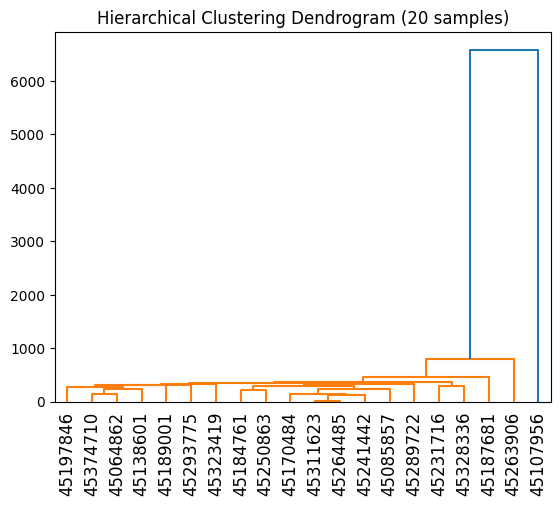

In [141]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, labels = sample.index, leaf_rotation = 90, **kwargs)

plt.title("Hierarchical Clustering Dendrogram (20 samples)")
# plot the top three levels of the dendrogram
plot_dendrogram(agglo_cluster, truncate_mode="level")
plt.savefig('nutrient_hierarchical_cluster_20samples.png', dpi=200, bbox_inches='tight')
plt.show()